In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 37.31 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [2]:
import os
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import plot_model
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import string
import random

In [3]:
# get the file path of training, testing and validation dataset

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# Data preprocessing

In [4]:
# Create a function that take a filename and return a list of all lines in a file
def get_lines(filename):
  with open(filename) as f:
    return f.readlines()

In [5]:
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

In [6]:
# Number of lines
len(train_lines)

35212

In [7]:

def preprocess_text_with_line_numbers(filename):
  """
  Create a function that read file and returns a list of dictionaries of abstract line data
          [{'line_number':0,
          'target': 'BACKGROUND',
          'text': 'Emotional eating is associated with overeating and the development of obesity',
          'total_lines: 11}
        ...]
  """
  input_lines = get_lines(filename)
  returned_list = []
  lines = ""

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      lines = ""

    elif line.isspace():
      line_split = lines.splitlines()

      for line_number, line in enumerate(line_split):
        line_data = {}
        target_text_split = line.split("\t")
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1]
        line_data['line_number'] = line_number
        line_data['total_lines'] = len(line_split) - 1
        returned_list.append(line_data)

    else:
      lines += line

  return returned_list


In [8]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[1])

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 389 ms, sys: 133 ms, total: 521 ms
Wall time: 528 ms


(30212, 180040, 30135)

In [9]:
# Check the first samples of training set
train_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'BACKGROUND',
  'text': 'It is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'OBJECTIVE',
  'text': 'We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'METHODS',
  'text': 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 9},
 {'targe

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9
1,BACKGROUND,It is not clear whether these patients would b...,1,9
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9
4,METHODS,Primary outcomes were improvement in quality o...,4,9


In [11]:
train_df['target'].value_counts()

METHODS        9964
RESULTS        9841
CONCLUSIONS    4582
BACKGROUND     3449
OBJECTIVE      2376
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

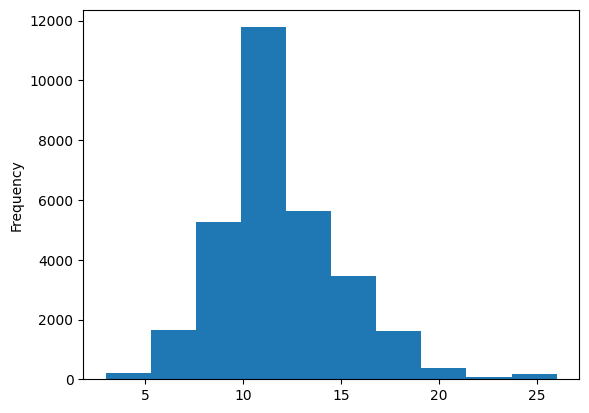

In [12]:
train_df.total_lines.plot.hist()

In [13]:
# sentences dataset
train_sentences = train_df['text'].tolist()
valid_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(valid_sentences), len(test_sentences)

(30212, 180040, 30135)

In [14]:
train_sentences[:5]

['IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
 'It is not clear whether these patients would benefit from antifungal treatment .',
 'We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
 'Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .']

In [15]:
# chars dataset
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in valid_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
len(train_chars), len(valid_chars), len(test_chars)

(30212, 180040, 30135)

In [16]:
train_chars[:5]

['I g E   s e n s i t i z a t i o n   t o   A s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'I t   i s   n o t   c l e a r   w h e t h e r   t h e s e   p a t i e n t s   w o u l d   b e n e f i t   f r o m   a n t i f u n g a l   t r e a t m e n t   .',
 'W e   s o u g h t   t o   d e t e r m i n e   w h e t h e r   a   @ - m o n t h   c o u r s e   o f   v o r i c o n a z o l e   i m p r o v e d   a s t h m a - r e l a t e d   o u t c o m e s   i n   p a t i e n t s   w i t h   a s t h m a   w h o   a r e   I g E   s e n s i t i z e d   t o   A   f u m i g a t u s   .',
 'A s t h m a t i c   p a t i e n t s   w h o   w e r e   I g E   s e n s i t i z e d   t o   A   f u m i g a t u s   w i t h   a   h i s t o r y   o f   a t   l e a s t   @   s e v e r e   e x a c e r b a t i o n s   i n   t h e   p r e v 

In [17]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encodedd = label_encoder.transform(test_df['target'].to_numpy())

train_labels_one_hot, train_labels_encoded

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([0, 0, 3, ..., 4, 1, 1]))

## Create char vectorizer

In [18]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.19111611280286

(array([1.8576e+04, 1.0579e+04, 9.2800e+02, 1.0600e+02, 1.6000e+01,
        5.0000e+00, 2.0000e+00]),
 array([   2.        ,  157.14285714,  312.28571429,  467.42857143,
         622.57142857,  777.71428571,  932.85714286, 1088.        ]),
 <BarContainer object of 7 artists>)

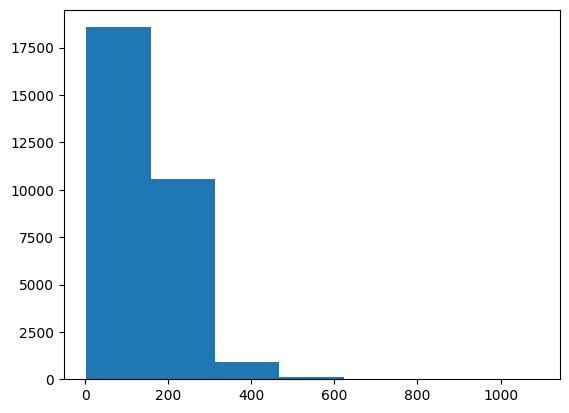

In [19]:
plt.hist(char_lens, bins=7)

In [20]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [21]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [22]:
# Create a char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                                               output_sequence_length=output_seq_char_len,
                                                                               name='char_vectorizer')

In [23]:
char_vectorizer.adapt(train_chars)

In [24]:
random_char_sample = random.choice(train_chars)
random_char_sample, char_vectorizer(random_char_sample)

('A   f u r t h e r   @   p a t i e n t s   w e r e   i n c l u d e d   o n   c o n t r o l   w a r d s   .',
 <tf.Tensor: shape=(290,), dtype=int64, numpy=
 array([ 5, 17, 16,  8,  3, 13,  2,  8, 14,  5,  3,  4,  2,  6,  3,  9, 20,
         2,  8,  2,  4,  6, 11, 12, 16, 10,  2, 10,  7,  6, 11,  7,  6,  3,
         8,  7, 12, 20,  5,  8, 10,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       

## Create a character-level embedding

In [25]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [26]:
char_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                       output_dim=25,
                                       mask_zero=True,
                                       name='char_embed')

## Character Model

In [27]:
# create a character baseline
num_classes = 5
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_char = tf.keras.Model(inputs, outputs)

model_char.compile(loss='categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

history_model_char = model_char.fit(train_char_dataset,
                                    steps_per_epoch=int(0.1 * len(train_char_dataset)),
                                    epochs=5,
                                    validation_data=val_char_dataset,
                                    validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/5
94/94 [==============================] - 7s 60ms/step - loss: 1.4866 - accuracy: 0.3763 - val_loss: 1.4419 - val_accuracy: 0.4434
Epoch 2/5
94/94 [==============================] - 5s 49ms/step - loss: 1.3823 - accuracy: 0.4355 - val_loss: 1.3469 - val_accuracy: 0.4346
Epoch 3/5
94/94 [==============================] - 6s 60ms/step - loss: 1.2843 - accuracy: 0.4621 - val_loss: 1.2282 - val_accuracy: 0.4877
Epoch 4/5
94/94 [==============================] - 13s 142ms/step - loss: 1.1861 - accuracy: 0.5043 - val_loss: 1.1648 - val_accuracy: 0.5207
Epoch 5/5
94/94 [==============================] - 14s 147ms/step - loss: 1.1445 - accuracy: 0.5402 - val_loss: 1.1252 - val_accuracy: 0.5328


## Sentences Model

In [28]:

train_token_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_token_dataset = tf.data.Dataset.from_tensor_slices((valid_sentences, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="use")

inputs = tf.keras.layers.Input(shape=(), dtype=tf.string)
x = sentence_encoder_layer(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_sentence = tf.keras.Model(inputs, outputs)

model_sentence.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

history_model_sentence = model_sentence.fit(train_token_dataset,
                                            epochs=5,
                                            steps_per_epoch=int(0.1 * len(train_token_dataset)),
                                            validation_data=valid_token_dataset,
                                            validation_steps=int(0.1 * len(valid_token_dataset)))


Epoch 1/5
94/94 [==============================] - 14s 126ms/step - loss: 1.3343 - accuracy: 0.4850 - val_loss: 1.1204 - val_accuracy: 0.5750
Epoch 2/5
94/94 [==============================] - 11s 120ms/step - loss: 0.9913 - accuracy: 0.6253 - val_loss: 0.9274 - val_accuracy: 0.6452
Epoch 3/5
94/94 [==============================] - 11s 120ms/step - loss: 0.8740 - accuracy: 0.6689 - val_loss: 0.8644 - val_accuracy: 0.6715
Epoch 4/5
94/94 [==============================] - 11s 121ms/step - loss: 0.8263 - accuracy: 0.6842 - val_loss: 0.8386 - val_accuracy: 0.6786
Epoch 5/5
94/94 [==============================] - 11s 121ms/step - loss: 0.8234 - accuracy: 0.6885 - val_loss: 0.8183 - val_accuracy: 0.6858


## Hybrid Model(character + sentences)

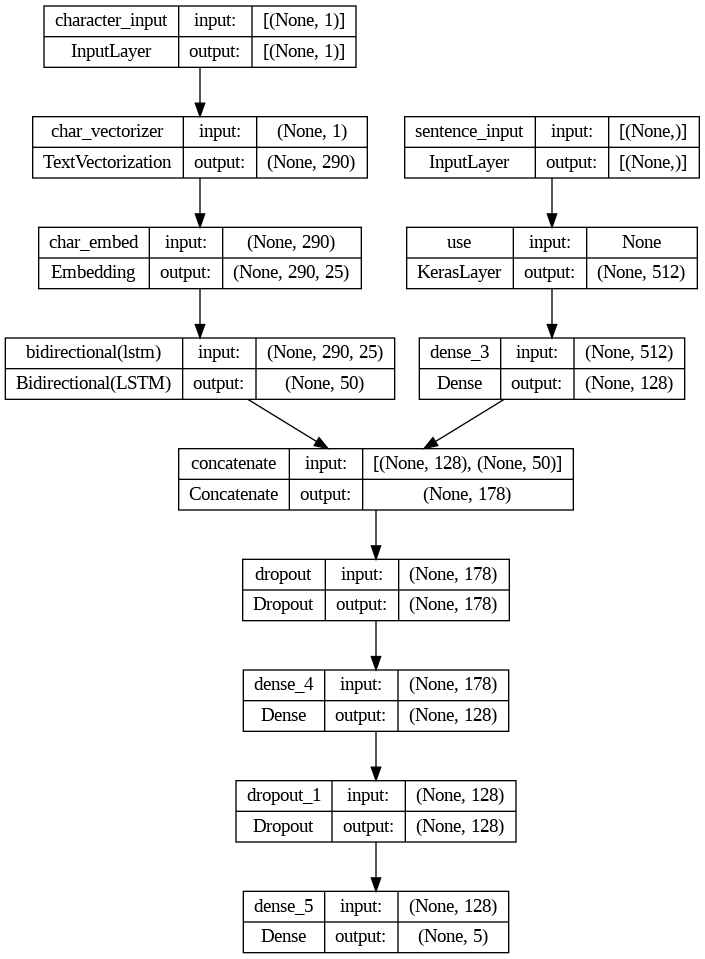

In [29]:
# tensorfow dataset training
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

#tensorflow dataset validation
valid_char_token_data = tf.data.Dataset.from_tensor_slices((valid_sentences, valid_chars))
valid_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
valid_char_token_dataset = tf.data.Dataset.zip((valid_char_token_data, valid_char_token_labels))
valid_char_token_dataset = valid_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# Create model character
char_inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name="character_input")
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed)
model_char = tf.keras.Model(char_inputs, char_bi_lstm)

# Create model sentence
sent_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentence_input")
sent_use = sentence_encoder_layer(sent_inputs)
sent_outputs = tf.keras.layers.Dense(128, activation='relu')(sent_use)
model_sent = tf.keras.Model(sent_inputs, sent_outputs)


# Concatenate model_char and model_sent outputs
concat_sent_char = tf.keras.layers.Concatenate()([model_sent.output, model_char.output])

# output layers
x = tf.keras.layers.Dropout(0.5)(concat_sent_char)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model_hybrid = tf.keras.Model([model_sent.input,model_char.input],
                              outputs)
plot_model(model_hybrid, show_shapes=True)

In [30]:
model_hybrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

history_model_hybrid = model_hybrid.fit(train_char_token_dataset,
                                        epochs=5,
                                        steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                                        validation_data=valid_char_token_dataset,
                                        validation_steps=int(0.1 * len(valid_char_token_dataset)))

Epoch 1/5
94/94 [==============================] - 81s 748ms/step - loss: 1.4289 - accuracy: 0.4402 - val_loss: 1.2563 - val_accuracy: 0.5913
Epoch 2/5
94/94 [==============================] - 56s 599ms/step - loss: 1.2452 - accuracy: 0.6054 - val_loss: 1.1870 - val_accuracy: 0.6449
Epoch 3/5
94/94 [==============================] - 66s 711ms/step - loss: 1.2014 - accuracy: 0.6316 - val_loss: 1.1548 - val_accuracy: 0.6724
Epoch 4/5
94/94 [==============================] - 66s 711ms/step - loss: 1.1844 - accuracy: 0.6543 - val_loss: 1.1405 - val_accuracy: 0.6829
Epoch 5/5
94/94 [==============================] - 78s 834ms/step - loss: 1.1761 - accuracy: 0.6669 - val_loss: 1.1284 - val_accuracy: 0.6916


## Feature engineer (total_line and line_number)

<Axes: ylabel='Frequency'>

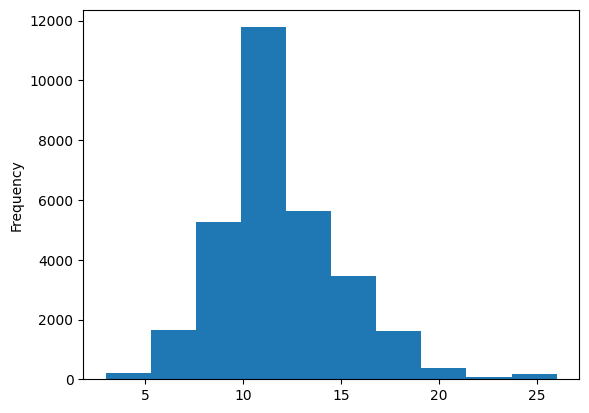

In [31]:
train_df['total_lines'].plot.hist()

In [32]:
np.percentile(train_df['total_lines'], 99)

21.0

In [33]:
# one-hot encoding total_lines with 21 of depth
train_total_line_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), 21)
valid_total_line_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), 21)
test_total_line_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), 21)
train_total_line_one_hot.shape, valid_total_line_one_hot.shape, test_total_line_one_hot.shape

(TensorShape([30212, 21]), TensorShape([180040, 21]), TensorShape([30135, 21]))

<Axes: ylabel='Frequency'>

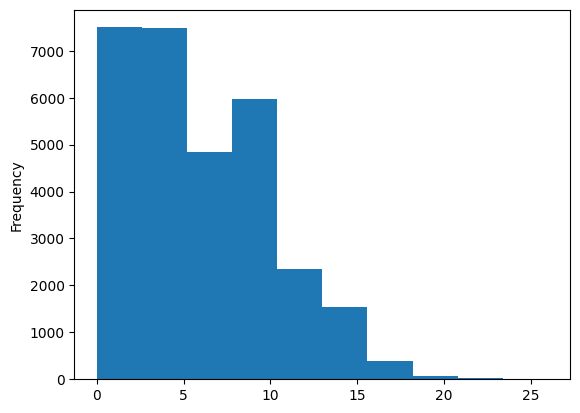

In [34]:
train_df['line_number'].plot.hist()

In [35]:
np.percentile(train_df['line_number'], 98)

15.0

In [36]:
# one-hot encoding line_number with depth of 15
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), 15)
valid_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), 15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), 15)
train_line_number_one_hot.shape, valid_line_number_one_hot.shape, test_line_number_one_hot.shape

(TensorShape([30212, 15]), TensorShape([180040, 15]), TensorShape([30135, 15]))

## Tribrid Model(character + sentences + (line_number + total_lines))

In [37]:
# Create tensorflow dataset
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_number_one_hot, train_total_line_one_hot))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

valid_tribrid_data = tf.data.Dataset.from_tensor_slices((valid_sentences, valid_chars, valid_line_number_one_hot, valid_total_line_one_hot))
valid_tribrid_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
valid_tribrid_dataset = tf.data.Dataset.zip((valid_tribrid_data, valid_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

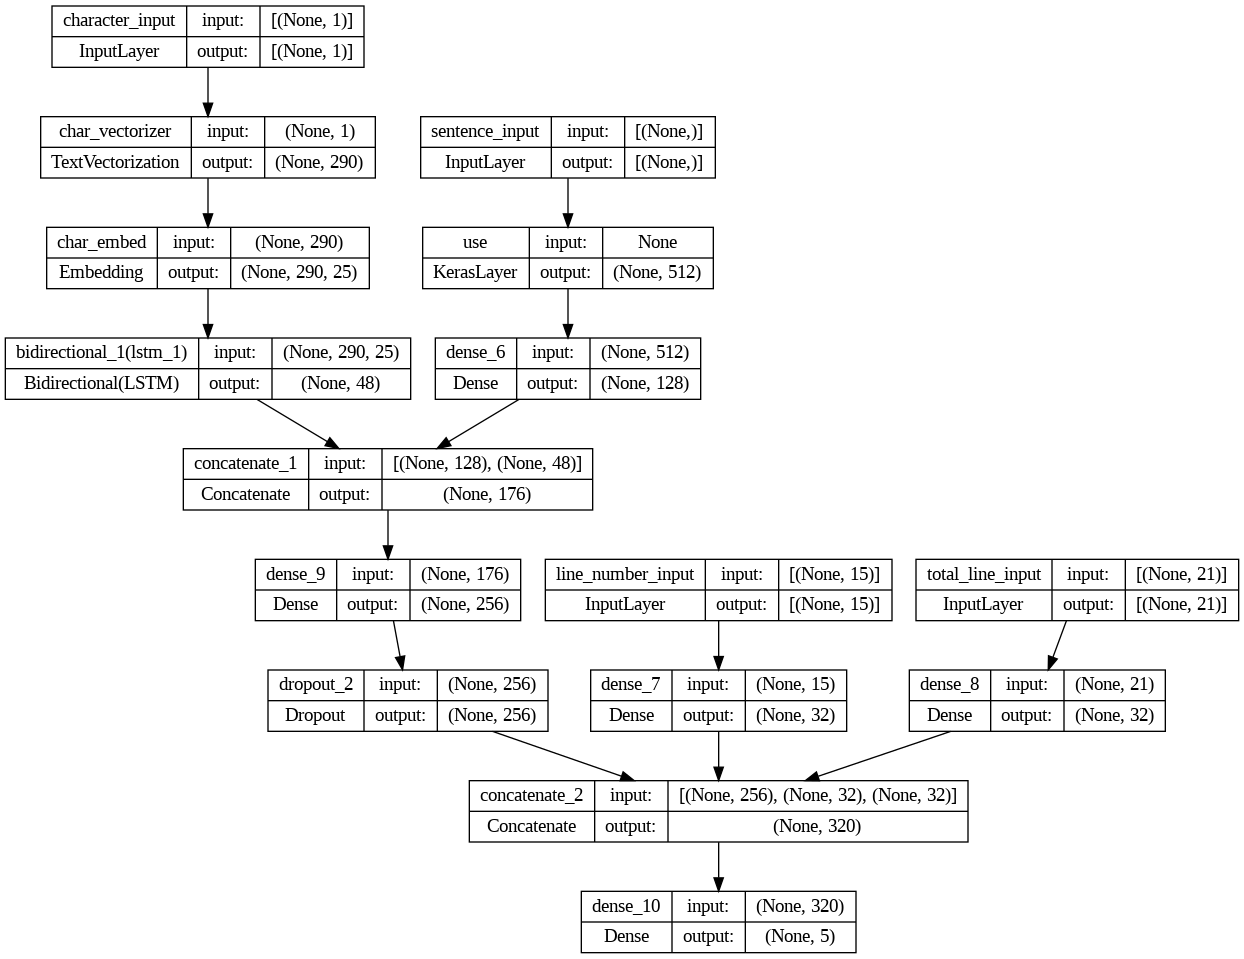

In [38]:
# sentences model
sent_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentence_input")
sent_use = sentence_encoder_layer(sent_inputs)
sent_outputs = tf.keras.layers.Dense(128, activation='relu')(sent_use)
model_sentence = tf.keras.Model(sent_inputs, sent_outputs)

# character model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="character_input")
char_vector = char_vectorizer(char_inputs)
char_embed = char_embedding(char_vector)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embed)
model_character = tf.keras.Model(char_inputs, char_bi_lstm)

#line number model
line_number_inputs = tf.keras.layers.Input(shape=(15,), name="line_number_input")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
model_line_number = tf.keras.Model(line_number_inputs, line_number_outputs)

# Total line model
total_line_inputs = tf.keras.layers.Input(shape=(21, ), name="total_line_input")
total_line_outputs = tf.keras.layers.Dense(32, activation="relu")(total_line_inputs)
model_total_line = tf.keras.Model(total_line_inputs, total_line_outputs)

# Concatenate the output of all
concat_char_sent = tf.keras.layers.Concatenate()([model_sentence.output, model_character.output])

x = tf.keras.layers.Dense(256, activation='relu')(concat_char_sent)
x = tf.keras.layers.Dropout(0.5)(x)

concat_all = tf.keras.layers.Concatenate()([x,
                                            model_line_number.output,
                                            model_total_line.output])

# Output layers
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(concat_all)

model_tribrid = tf.keras.Model([model_sentence.input,
                                model_character.inputs,
                                model_line_number.input,
                                model_total_line.input], outputs)

plot_model(model_tribrid, show_shapes=True)

In [39]:
model_tribrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

history_model_tribrid = model_tribrid.fit(train_tribrid_dataset,
                                          epochs=5,
                                          steps_per_epoch=len(train_tribrid_dataset),
                                          validation_data=valid_tribrid_dataset,
                                          validation_steps=len(valid_tribrid_dataset))

Epoch 1/5
112/945 [==>...........................] - ETA: 3:39 - loss: 1.3182 - accuracy: 0.5416

KeyboardInterrupt: 

(None, 290)
(None, 290, 25)
(None, 48)


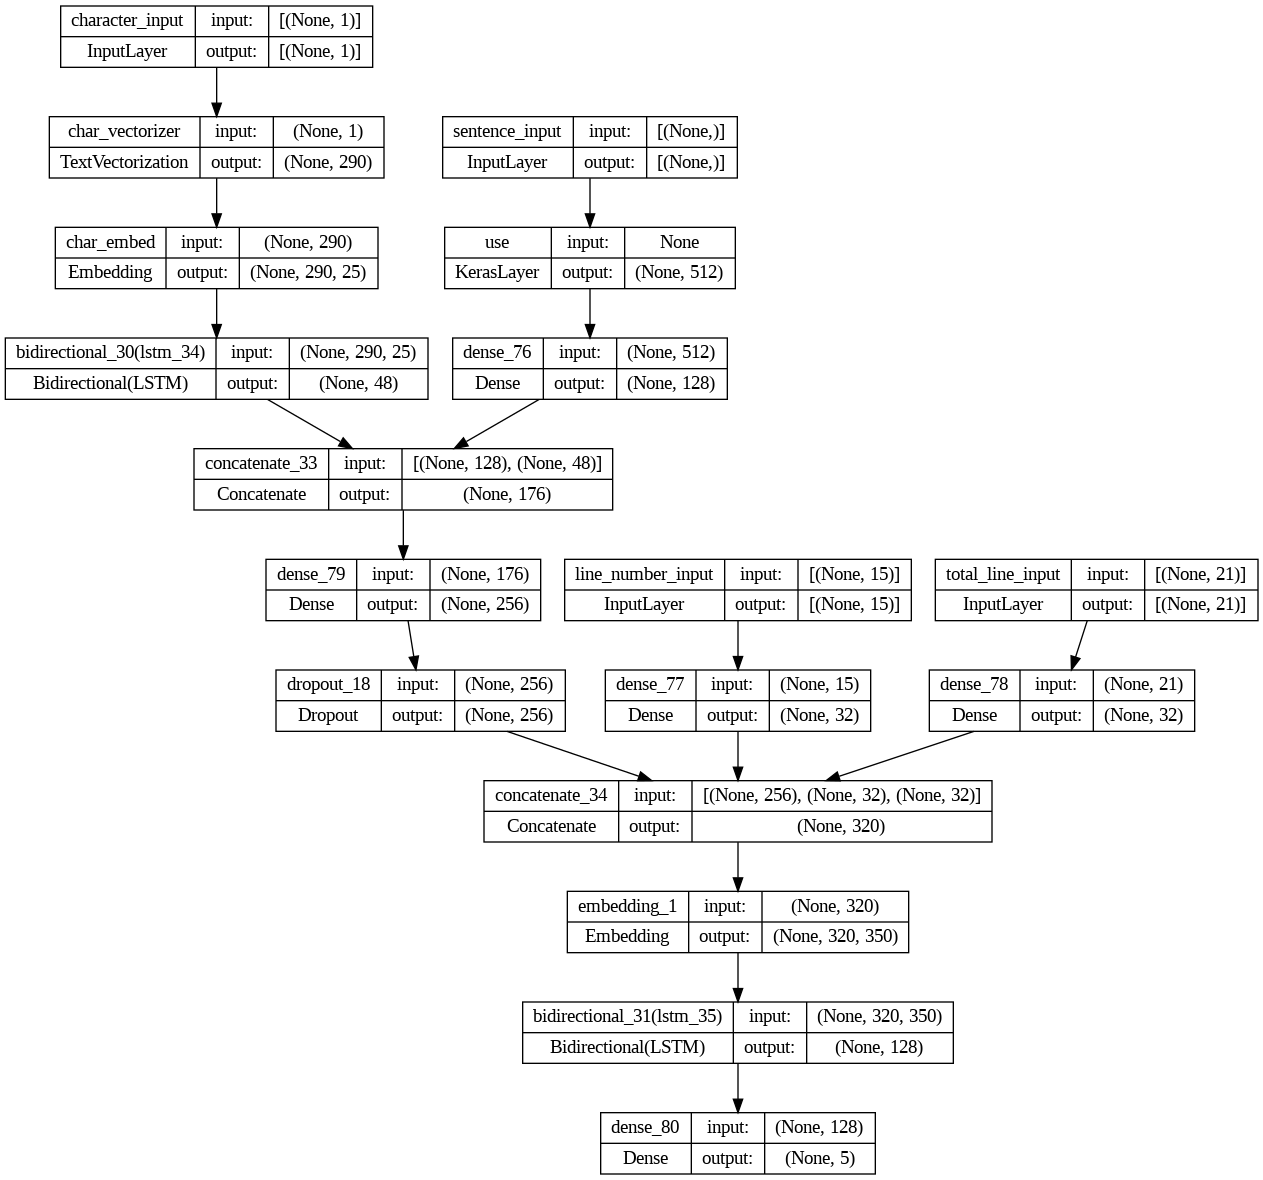

In [55]:
# sentences model
sent_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="sentence_input")
sent_use = sentence_encoder_layer(sent_inputs)
sent_outputs = tf.keras.layers.Dense(128, activation='relu')(sent_use)
model_sentence = tf.keras.Model(sent_inputs, sent_outputs)

# character model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="character_input")
char_vector = char_vectorizer(char_inputs)
print(char_vector.get_shape())
char_embed = char_embedding(char_vector)
print(char_embed.get_shape())
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embed)
print(char_bi_lstm.get_shape())
model_character = tf.keras.Model(char_inputs, char_bi_lstm)

#line number model
line_number_inputs = tf.keras.layers.Input(shape=(15,), name="line_number_input")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
model_line_number = tf.keras.Model(line_number_inputs, line_number_outputs)

# Total line model
total_line_inputs = tf.keras.layers.Input(shape=(21, ), name="total_line_input")
total_line_outputs = tf.keras.layers.Dense(32, activation="relu")(total_line_inputs)
model_total_line = tf.keras.Model(total_line_inputs, total_line_outputs)

# Concatenate the output of all
concat_char_sent = tf.keras.layers.Concatenate()([model_sentence.output, model_character.output])

x = tf.keras.layers.Dense(256, activation='relu')(concat_char_sent)
x = tf.keras.layers.Dropout(0.5)(x)

concat_all = tf.keras.layers.Concatenate()([x,
                                            model_line_number.output,
                                            model_total_line.output])

# Output layers


concat_embed = tf.keras.layers.Embedding(input_dim=concat_all.get_shape()[-1],
                                      output_dim=350)(concat_all)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(concat_embed)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(bi_lstm)

model_tribrid = tf.keras.Model([model_sentence.input,
                                model_character.inputs,
                                model_line_number.input,
                                model_total_line.input], outputs)

plot_model(model_tribrid, show_shapes=True)

In [ ]:
model_tribrid.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

history_model_tribrid = model_tribrid.fit(train_tribrid_dataset,
                                          epochs=5,
                                          validation_data=valid_tribrid_dataset)

Epoch 1/5


 51/945 [>.............................] - ETA: 13:53 - loss: 1.5298 - accuracy: 0.3051